# Statistical analysis - experiment 2 

### Import the libraries 

In [1]:
import os
import numpy as np
import pandas as pd
from csv import reader
from statsmodels.stats.anova import AnovaRM
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline 

### Function to collect all csv-files in the folder

In [2]:
def list_csv_files(resultsdir):
    csv_files = []

    if os.path.isdir(resultsdir):
        for root, dirs, files in list(os.walk(resultsdir)):
            for name in files:
                subdir = root.split(resultsdir)
                all('' == s for s in subdir)
                
                if subdir[1].startswith('/'):
                    subdirname = subdir[1][1:]
                else:
                    subdirname = subdir[1]

                if name.lower().endswith('.csv'):
                    if all('' == s for s in subdir):
                        csv_files.append(name)
                    else:
                        csv_files.append(os.path.join(subdirname, name))
    
        csv_files.sort()

    return csv_files

### Function to get all unique combinations

In [3]:
def get_unique_combinations(csv_files):
    unique_combinations = []
    for c in range(len(csv_files)):
        csv_file = csv_files[c]
        splits = csv_file.split("/")
        run_no = splits[0].split("run")[-1]
        sam_mt = splits[1].split("_")[0]
        unc_mt = splits[1].split("_")[1]
        prob = splits[1].split("_")[2]
        fwp = splits[1].split("_")[3]
        sam_sz = splits[1].split("_")[4]
        unique_combination = sam_mt + '_' + unc_mt + '_' + prob + '_' + fwp + '_' + sam_sz
        unique_combinations.append(unique_combination)
    return list(set(unique_combinations))

### Load the csv-files and store the data in a pandas-dataframe 

In [4]:
resultsdir = "results/exp2"
two_up = os.path.abspath(os.path.join(os.getcwd(),"../.."))
resultsdir = os.path.join(two_up, resultsdir)
csv_files = list_csv_files(resultsdir)

clmns = ["sampling_method", "uncertainty_method", "dropout_probability", "number_forward_passes", "sampling_size", "unique_combination", "run", "number_images", "mAP"]
df = pd.DataFrame(columns=clmns)
unique_combinations = get_unique_combinations(csv_files)

for c in range(len(csv_files)):
    csv_file = csv_files[c]
    splits = csv_file.split("/")
    run_no = splits[0].split("run")[-1]
    sam_mt = splits[1].split("_")[0]
    unc_mt = splits[1].split("_")[1]
    prob = splits[1].split("_")[2]
    fwp = splits[1].split("_")[3]
    sam_sz = splits[1].split("_")[4]
    unique_combination = sam_mt + '_' + unc_mt + '_' + prob + '_' + fwp + '_' + sam_sz
    uc_id = unique_combinations.index(unique_combination)

    with open(os.path.join(resultsdir, csv_file), 'r') as read_obj:
        csv_reader = reader(read_obj)
        next(csv_reader)
        for row in csv_reader:
            data = [sam_mt, unc_mt, float(prob), int(fwp), int(sam_sz), int(uc_id), int(run_no), int(row[0]), float(row[1])]
            df.loc[len(df)] = data

### Plot the performance for each of the combinations

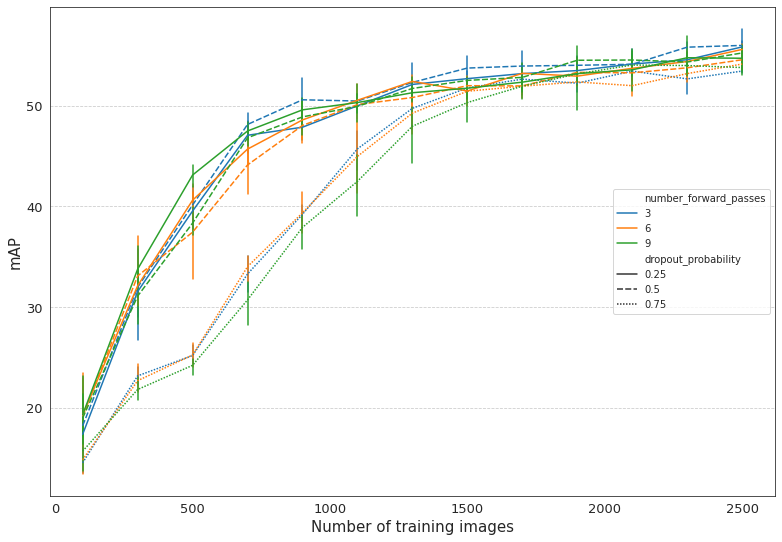

In [5]:
font_size = 15
digit_size = 13
annot_size = 14

sns.set_style("whitegrid")
sns.set_style("white")
f, ax = plt.subplots(figsize=(13, 9))
# ax = sns.lineplot(x="number_images", y="mAP", hue="number_forward_passes", size="uncertainty_method", style="dropout_probability", err_style="bars", ci=95, data=df)
ax = sns.lineplot(x="number_images", y="mAP", hue="number_forward_passes", style="dropout_probability", err_style="bars", ci=95, data=df, palette = "tab10")
ax.grid(which='major', axis='y', linestyle='--')
ax.tick_params(labelrotation=0, labelsize=digit_size)

plt.xlabel('Number of training images', fontsize=font_size)
plt.ylabel('mAP', fontsize=font_size)
plt.legend(loc='center right')
plt.show()

### ANOVA with repeated measures 

In [6]:
## one-way ANOVA on the unique_combination with repeated measures on the runs
# aovrm = AnovaRM(data=df, depvar='mAP', subject='run', within=['unique_combination'], aggregate_func='mean')

## two-way ANOVA on the unique_combination and the number_images with repeated measures on the runs
# aovrm = AnovaRM(data=df, depvar='mAP', subject='run', within=['unique_combination', 'number_images'])

## two-way ANOVA on the dropout_probability and the number_forward_passes with repeated measures on the runs
mean = df.groupby(['dropout_probability', 'number_forward_passes']).mean()
var = df.groupby(['dropout_probability', 'number_forward_passes']).var()
aovrm = AnovaRM(data=df, depvar='mAP', subject='run', within=['dropout_probability', 'number_forward_passes'], aggregate_func='mean')

## three-way ANOVA on the dropout_probability and the number_forward_passes with repeated measures on the runs
# mean = df.groupby(['dropout_probability', 'number_forward_passes', 'number_images']).mean()
# var = df.groupby(['dropout_probability', 'number_forward_passes', 'number_images']).var()
# aovrm = AnovaRM(data=df, depvar='mAP', subject='run', within=['dropout_probability', 'number_forward_passes', 'number_images'])

res = aovrm.fit()
print(mean)
print(var)
print(res)

                                                 mAP
dropout_probability number_forward_passes           
0.25                3                      46.861538
                    6                      46.951923
                    9                      47.307692
0.50                3                      47.634615
                    6                      46.263462
                    9                      46.888462
0.75                3                      42.065385
                    6                      41.942308
                    9                      41.373077
                                                  mAP
dropout_probability number_forward_passes            
0.25                3                      120.167511
                    6                      107.683722
                    9                      101.177979
0.50                3                      121.928974
                    6                      108.845109
                    9                  

### Miscellaneous calculations - ANOVA table

In [7]:
# https://www.statsmodels.org/devel/examples/notebooks/generated/interactions_anova.html#Two-way-ANOVA
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

nosum_lm = ols("mAP ~ C(dropout_probability) * C(number_forward_passes)", data=df).fit()
print(anova_lm(nosum_lm))

                                                    df        sum_sq  \
C(dropout_probability)                             2.0   2803.432094   
C(number_forward_passes)                           2.0     18.054530   
C(dropout_probability):C(number_forward_passes)    4.0     50.926752   
Residual                                         459.0  61816.988077   

                                                     mean_sq          F  \
C(dropout_probability)                           1401.716047  10.407943   
C(number_forward_passes)                            9.027265   0.067029   
C(dropout_probability):C(number_forward_passes)    12.731688   0.094535   
Residual                                          134.677534        NaN   

                                                   PR(>F)  
C(dropout_probability)                           0.000038  
C(number_forward_passes)                         0.935177  
C(dropout_probability):C(number_forward_passes)  0.984175  
Residual               

### Miscellaneous calculations - Least Significant Difference

In [8]:
# https://www.statology.org/fishers-least-significant-difference/
# https://personal.utdallas.edu/~herve/abdi-LSD2010-pretty.pdf
# https://stackoverflow.com/questions/19339305/python-function-to-get-the-t-statistic
# Studnt, n=999, p<0.05, 2-tail
den_df = 12
runs = 4
ms_res = 134.677534
t = stats.t.ppf(1-0.025, den_df)
LSD = t * np.sqrt(ms_res * (2/runs))
print(round(LSD,2))

17.88
